In [1]:
from dotenv import load_dotenv
import os
from tradesystem.adapters.clients import PolyMarketInfo
from tradesystem.adapters.clients.binance_info_api import BinanceEOptionsClient
import json
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import matplotlib.patches as patches


load_dotenv()
private_key = os.getenv("PRIVATEKEY")

SLUGS = ["what-price-will-bitcoin-hit-in-2025", "what-price-will-bitcoin-hit-in-august"]
btcEvent = PolyMarketInfo.get_events(slug = SLUGS[0], closed = "false")[0]

with open("./btcmarkets.json", "w") as f:
    json.dump(btcEvent, f, indent=4)

btcmarkets = [PolyMarketInfo.get_markets(id=market["id"])[0] for market in  btcEvent["markets"] if not market["closed"]]

{'slug': 'what-price-will-bitcoin-hit-in-2025', 'closed': 'false'}


In [2]:
print(btcmarkets)

[{'id': 516861, 'question': 'Will Bitcoin reach $1,000,000 by December 31, 2025?', 'conditionId': '0xd8b9ff369452daebce1ac8cb6a29d6817903e85168356c72812317f38e317613', 'slug': 'will-bitcoin-reach-1000000-by-december-31-2025', 'resolutionSource': '', 'endDate': '2025-12-31T12:00:00Z', 'liquidity': 212629.34907, 'startDate': '2024-12-30T22:00:50.534Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/BTC+fullsize.png', 'description': 'This market will immediately resolve to "Yes" if any Binance 1 minute candle for Bitcoin (BTCUSDT) between December 30, 2024, 20:00 and December 31, 2025, 23:59 in the ET timezone has a final "High" price of $1,000,000 or higher. Otherwise, this market will resolve to "No."\n\nThe resolution source for this market is Binance, specifically the BTCUSDT "High" prices available at https://www.binance.com/en/trade/BTC_USDT, with the chart settings on "1m" for one-minut

In [3]:
# Market stuff

import re
from decimal import Decimal, getcontext#
from functools import lru_cache
getcontext().prec = 50  # avoid float rounding on big IDs/money

pattern = re.compile(r"\$([\d.,]+)([KMB]?)", re.IGNORECASE)

def extract_dollar_amount(question: str) -> int | None:
    m = pattern.search(question)
    if not m:
        return None
    
    number_str, suffix = m.groups()
    number = float(number_str.replace(",", ""))
    
    multiplier = {
        "": 1,
        "K": 1_000,
        "M": 1_000_000,
        "B": 1_000_000_000,
    }
    
    return int(number * multiplier[suffix.upper()])

def calculateInstantBuyPriceAndAmountOfShares(
    positions,
    amountOfMoney: float,
    order_type: str = "FAK",# "FAK" or "FOK"
) -> float:
    if not positions:
        return None

    bookSorted = sorted(positions, key=lambda p: Decimal(str(p.price)))

    remaining = Decimal(str(amountOfMoney))
    total_cost = Decimal("0")
    total_size = Decimal("0")
    
    for ask in bookSorted:
        price = Decimal(str(ask.price))
        size_avail = Decimal(str(ask.size))

        level_cost_when_buying_whole_level = size_avail * price
        take_cost = min(remaining, level_cost_when_buying_whole_level)

        if take_cost > Decimal("0"):
            total_cost += take_cost
            total_size += take_cost / price
            remaining -= take_cost
        else:
            break
        
    if order_type.upper() == "FOK" and remaining > 0:
        return None,None

    if total_size == 0:
        return None,None

    return float(total_cost / total_size), float(total_size)

def calculateAverageBuyPrice(
    positions,
    amount_to_match: float,
    order_type
) -> float:
    if not positions:
        raise Exception("no match")

    sum = 0
    avgPrice = 0
    for p in reversed(positions):
        coveredByTheseShares = float(p.size) * float(p.price)
        sum += float(p.size) * float(p.price)
        if sum >= amount_to_match:
            return float(p.price)

    if order_type == "FOK":
        raise Exception("no match")

    return float(positions[0].price)


def calculate_sell_market_price(
    positions,
    amount_to_match: float,
    order_type
) -> float:
    if not positions:
        raise Exception("no match")

    sum = 0
    for p in reversed(positions):
        sum += float(p.size)
        if sum >= amount_to_match:
            return float(p.price)

    if order_type == "FOK":
        raise Exception("no match")

    return float(positions[0].price)

def calculate_market_price_for_instant_trade(
    token_id: str, side: str, amount: float, order_type
) -> float:
    """
    Calculates the matching price considering an amount and the current orderbook
    """
    book = PolyMarketInfo().client.get_order_book(token_id)
    if book is None:
        raise Exception("no orderbook")
    if side == "BUY":
        return calculateInstantBuyPriceAndAmountOfShares(
            book.asks, amount, order_type
        )
    else:
        raise ValueError("Only BUY side is supported in this function")
        return calculate_sell_market_price(
            book.bids, amount, order_type
        )

from tradesystem.domain.order_book import OrderBook
def getOrderBookForPolyMarket(market:dict) -> OrderBook:
    globToken = market["clobTokenIds"][1] # assume no for now
    response = requests.get(f"https://clob.polymarket.com/book?token_id={globToken}")
    if response.status_code != 200:
        raise Exception("no orderbook")
    data = response.json()
    return OrderBook(globToken, {"bids": [bid.values() for bid in data["bids"]], "asks": [ask.values() for ask in data["asks"]]})


def getUpperLimitForPolyMarketShort(market: dict) -> float:
    """
    Returns the bitcoin price at which the bet resolves to 0
    """
    return float(extract_dollar_amount(market['question']))

import requests
def get_btc_price_usd():
    url = "https://api.binance.com/api/v3/ticker/price"
    params = {"symbol": "BTCUSDT"}
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
    except requests.RequestException as err:
        raise RuntimeError(f"Error fetching BTC price: {err}")

    data = response.json()
    if "price" in data:
        return float(data["price"])
    else:
        raise ValueError(f"Unexpected response format: {data}")


def get_btc_put_for_strike(strike):
    if strike == 90000:
        return 1980



def getClosingDateMarket(market: dict) -> datetime:
    """
    Returns the closing date of the market.
    """
    if 'endDateIso' in market:
        return datetime.fromisoformat(market['endDateIso'])
    elif 'end_date' in market:
        print(market["end_date"])
    return None


def extract_strike_binance(symbol: str) -> float:
    """
    Extract strike price from a Binance option symbol like 'BTC-251226-100000-P'.
    Returns as float.
    """
    try:
        # Format: UNDERLYING-YYMMDD-STRIKE-SIDE
        parts = symbol.split("-")
        if len(parts) < 4:
            raise ValueError(f"Unexpected symbol format: {symbol}")
        return float(parts[2])
    except Exception:
        return float("nan")



In [4]:
# Strategy

class DeltaHedgeStrategy_NoFees:
    """
    This strategy goes long short:
    * Short on Polymarket,
    * Spot on binance,
    * No slippage/fees are assumed for all trades,

    This strategy assumes buy and hold and does not react on market movement.
    --> Can lead to losses as we see in calculate_pay_off_curve_buy_and_hold.
    This strategy can be used as a base for more advanced strategies.

    Inputs:
    - minrelativeGain: The minimum gain even if the bet is lost. --> not implemnted --> Can be set abs or relative by {"abs":val} or {"rel":val}
    - capital_to_invest: the amount of capital to invest in the strategy
    - bitcoin_market: the current state of the bitcoin market
    - polymarket: the current state of the polymarket

    Algorithm:
    We go long on Binance and short on Polymarket.
    We only trade bitcoin on binance and keep the bet on polymarket until the market closes.
    """
    def __init__(self, minAbsGain:float, capital_to_invest, bitcoinMarket:dict, polyMarket:dict):
        self.minrelativeGain = minAbsGain/capital_to_invest
        self.capital_to_invest = capital_to_invest
        self.min_profit = minAbsGain
        self.bitcoinMarket = bitcoinMarket # not used for now keep it static
        self.polymarket = polyMarket

    def calculate_personal_hedge(self, btcPrice, upwardslimit):
        """
        Calculates the concrete amount of capital to hedge. Considering the invested capital and interest rate in this strategy

        btcPrice: float or np.ndarray of shape (n,)
        upwardslimit: float, the upper bound bitcoin price when the hedge goes to the zero

        return: returns the amount of money which should be used for hedging in this strategy

        """
        assert isinstance(upwardslimit, float), "upwardslimit must be a float"

        delta_to_limit = upwardslimit - btcPrice
        hedgeForOneBitcoin = (delta_to_limit - self.minrelativeGain * btcPrice) / (1 + self.minrelativeGain)
        return (hedgeForOneBitcoin/ (hedgeForOneBitcoin + btcPrice)) * self.capital_to_invest

    def get_anual_profit_for_payoff_curve(self, relativeProfit: np.ndarray) -> np.ndarray:
        """
        Converts the relative profit to annual profit.
        relativeProfit: np.ndarray of shape (n,) with relative profit values
        """
        closingDate = getClosingDateMarket(self.polymarket)
        if closingDate is None:
            return None
        currentDate = datetime.now()
        timeInTheMarket = closingDate - currentDate
        if relativeProfit is None:
            return None
        return (relativeProfit/timeInTheMarket.days) * 365

    @staticmethod
    def get_interest_rate_for_remaining_time(anual_interest_rate, timedelta):
        return (anual_interest_rate / 365) * timedelta.days

    def calculate_pay_off_curve_buy_now_and_hold(self, bitcoin_prices:np.ndarray):
        """
        Calculates the pay-off curve for given final prices when the strategy is to buy and hold.
        """
        currentBtcPrice = get_btc_price_usd()
        upperLimit = getUpperLimitForPolyMarketShort(self.polymarket)

        if upperLimit < currentBtcPrice:
            print(f"upperLimit {upperLimit} must be greater than currentBtcPrice {currentBtcPrice} check market data there must be an error")
            return None

        personal_short_hedge_input = self.calculate_personal_hedge(currentBtcPrice, upperLimit)

        # calulate bet conditions
        orderBook = getOrderBookForPolyMarket(self.polymarket)
        avgPrice, personal_short_hedge_gain = orderBook.calculate_instant_buy_price_and_size(amount_of_money=personal_short_hedge_input, order_type="FOK")
        if personal_short_hedge_gain is None:
            print("Too much capital needed for short hedge")
            return None

        personal_long = self.capital_to_invest - personal_short_hedge_input

        if personal_long < 0:
            print("Market is not profitable at all")
            return None

        print(f"Invested in spot: {personal_long}")
        print(f"Invested in bet: {personal_short_hedge_input}")


        print(f"Invested in general: {personal_long + personal_short_hedge_input}, capital used for calulction: {self.capital_to_invest}")
        print(f"Gain When bet wins: {personal_short_hedge_gain - personal_short_hedge_input} with avg price: {avgPrice}")

        # 1.case (bitcoin goes above upwardslimit)
        bitcoin_delta_price = bitcoin_prices[bitcoin_prices >= upperLimit] - currentBtcPrice
        personal_profit = -self.capital_to_invest + ((bitcoin_delta_price +currentBtcPrice) / currentBtcPrice) * personal_long - self.min_profit

        #2. case (bitcoin stays below limit)
        bitcoin_delta_price = bitcoin_prices[bitcoin_prices < upperLimit] - currentBtcPrice
        personal_profit_below_limit = -self.capital_to_invest + ((bitcoin_delta_price +currentBtcPrice) / currentBtcPrice) * personal_long + personal_short_hedge_gain - self.min_profit
        
        personalAbsoluteProfitDistribution = np.concatenate([personal_profit_below_limit, personal_profit])
        personalRelativeProfitDistribution = personalAbsoluteProfitDistribution / self.capital_to_invest

        return personalRelativeProfitDistribution

In [5]:
# Binance put options


client = BinanceEOptionsClient()
syms = client.btc_put_symbols(
    strike_range=(70000, 120000),
    closing_time_range=("2025-12-26", "2025-12-31"),
)

books = client.depths(syms)

for k,v in books.items():
    print(f"{k}: {v}")

    strike = extract_strike_binance(k)
    print(f"Extracted strike: {strike}")

BTC-251226-100000-P: <OrderBook BTC-251226-100000-P | bid=(3455.0, 5.28) ask=(3595.0, 1.39) spread=140.0>
Extracted strike: 100000.0
BTC-251226-105000-P: <OrderBook BTC-251226-105000-P | bid=(4755.0, 5.12) ask=(4900.0, 1.19) spread=145.0>
Extracted strike: 105000.0
BTC-251226-110000-P: <OrderBook BTC-251226-110000-P | bid=(6380.0, 4.95) ask=(6580.0, 1.0) spread=200.0>
Extracted strike: 110000.0
BTC-251226-115000-P: <OrderBook BTC-251226-115000-P | bid=(8410.0, 4.8) ask=(8660.0, 0.98) spread=250.0>
Extracted strike: 115000.0
BTC-251226-120000-P: <OrderBook BTC-251226-120000-P | bid=(10855.0, 5.69) ask=(11145.0, 0.97) spread=290.0>
Extracted strike: 120000.0
BTC-251226-70000-P: <OrderBook BTC-251226-70000-P | bid=(500.0, 0.2) ask=(565.0, 1.92) spread=65.0>
Extracted strike: 70000.0
BTC-251226-75000-P: <OrderBook BTC-251226-75000-P | bid=(640.0, 2.6) ask=(745.0, 1.92) spread=105.0>
Extracted strike: 75000.0
BTC-251226-80000-P: <OrderBook BTC-251226-80000-P | bid=(905.0, 5.7) ask=(1005.0, 

Bitcoin price USD: 116976.78
Invested in put option (BTC-251226-100000-P),3595.0: 719.0
Invested in spot: 19366.171820934134
Invested in bet: 4748.184179065866
Invested in general: 24114.356, capital used for calulction: 24114.356
Gain When bet wins: 2639.960711804697 with avg price: 0.6426761046515393



Invested in spot: 22345.58478056677
Invested in bet: 1768.7712194332312
Invested in general: 24114.356, capital used for calulction: 24114.356
Gain When bet wins: 4127.132845344206 with avg price: 0.3
FOUND



Invested in spot: 23239.40817178944
Invested in bet: 874.9478282105603
Invested in general: 24114.356, capital used for calulction: 24114.356
Gain When bet wins: 4263.826342470572 with avg price: 0.17026391881599034
FOUND





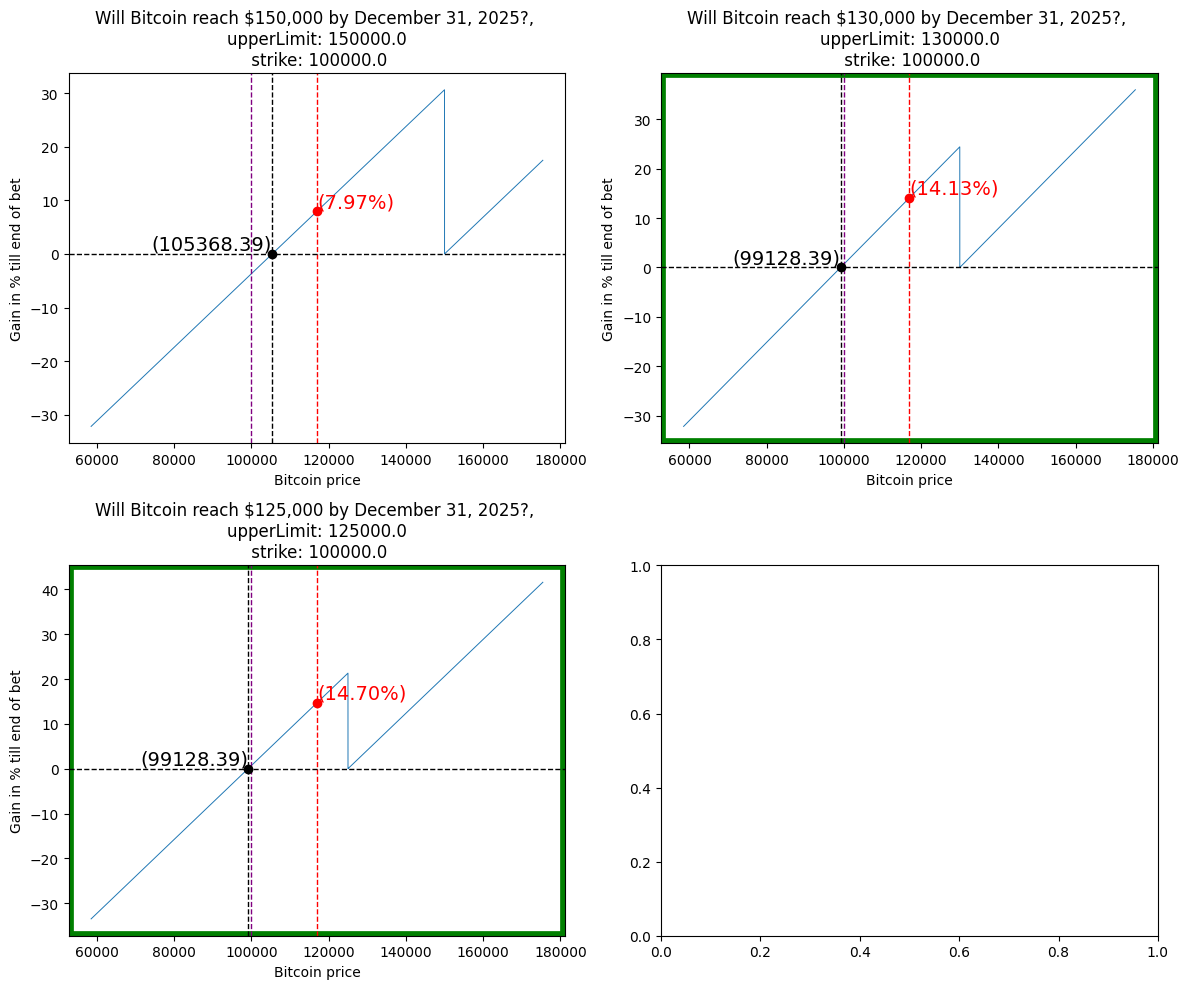

Bitcoin price USD: 116976.78
Invested in put option (BTC-251226-105000-P),4900.0: 980.0
Invested in spot: 19773.250980534132
Invested in bet: 4602.105019465866
Invested in general: 24375.356, capital used for calulction: 24375.356
Gain When bet wins: 2561.302702789313 with avg price: 0.6424463325140782



Invested in spot: 22815.289592924
Invested in bet: 1560.0664070759992
Invested in general: 24375.356, capital used for calulction: 24375.356
Gain When bet wins: 3640.154949843998 with avg price: 0.3
FOUND



Invested in spot: 23727.90117664096
Invested in bet: 647.4548233590392
Invested in general: 24375.356, capital used for calulction: 24375.356
Gain When bet wins: 3192.710253417048 with avg price: 0.16860077898072898





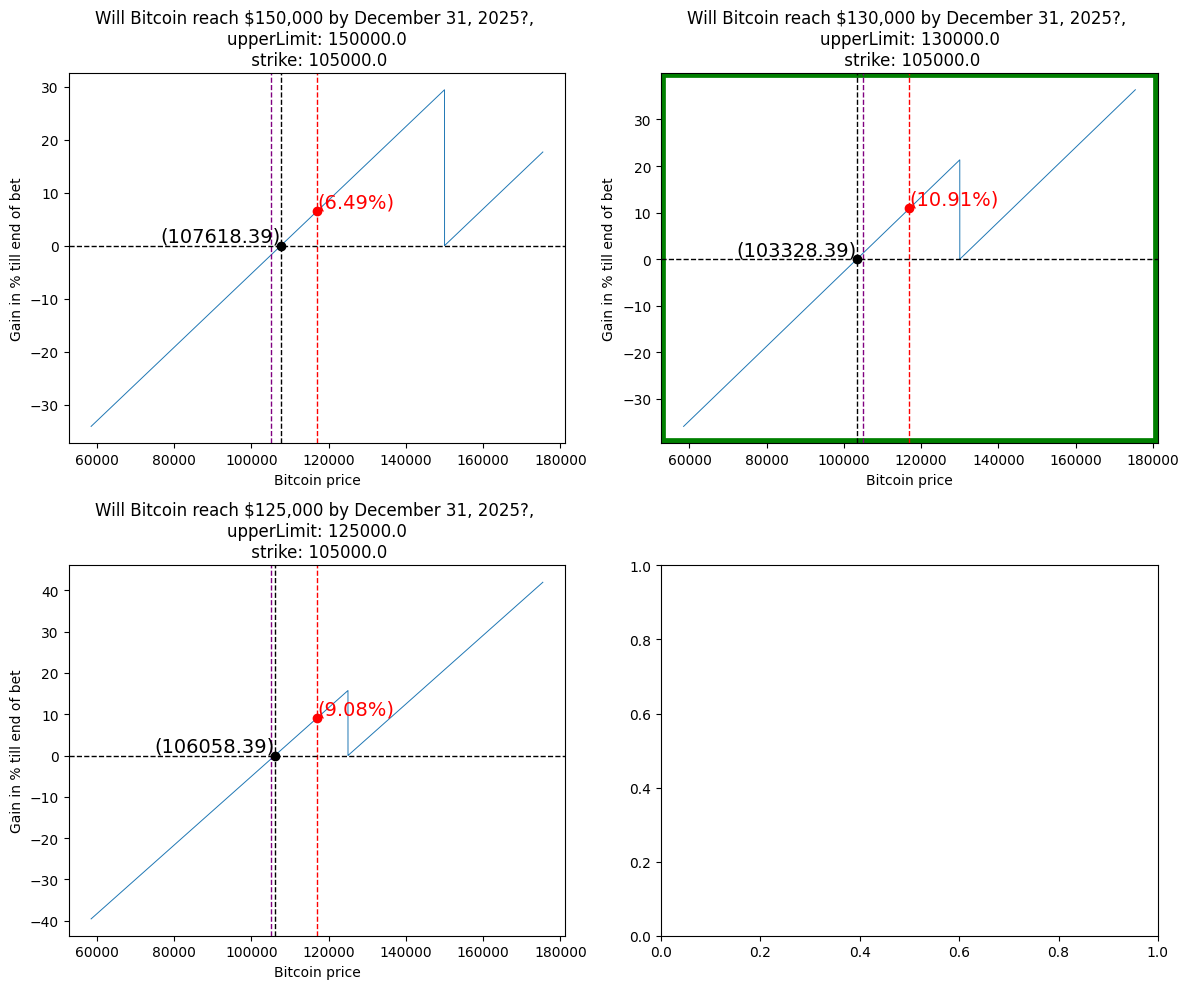

Bitcoin price USD: 116976.77
Invested in put option (BTC-251226-110000-P),6580.0: 1316.0
Invested in spot: 20297.30535044387
Invested in bet: 4414.048649556134
Invested in general: 24711.354000000003, capital used for calulction: 24711.354000000003
Gain When bet wins: 2460.0415805302264 with avg price: 0.6421284128970008



Invested in spot: 23419.969714154773
Invested in bet: 1291.384285845231
Invested in general: 24711.354000000003, capital used for calulction: 24711.354000000003
Gain When bet wins: 3013.230000305539 with avg price: 0.3
FOUND



Invested in spot: 24356.768502720963
Invested in bet: 354.5854972790404
Invested in general: 24711.354000000003, capital used for calulction: 24711.354000000003
Gain When bet wins: 1764.8002008104859 with avg price: 0.1673057894080694





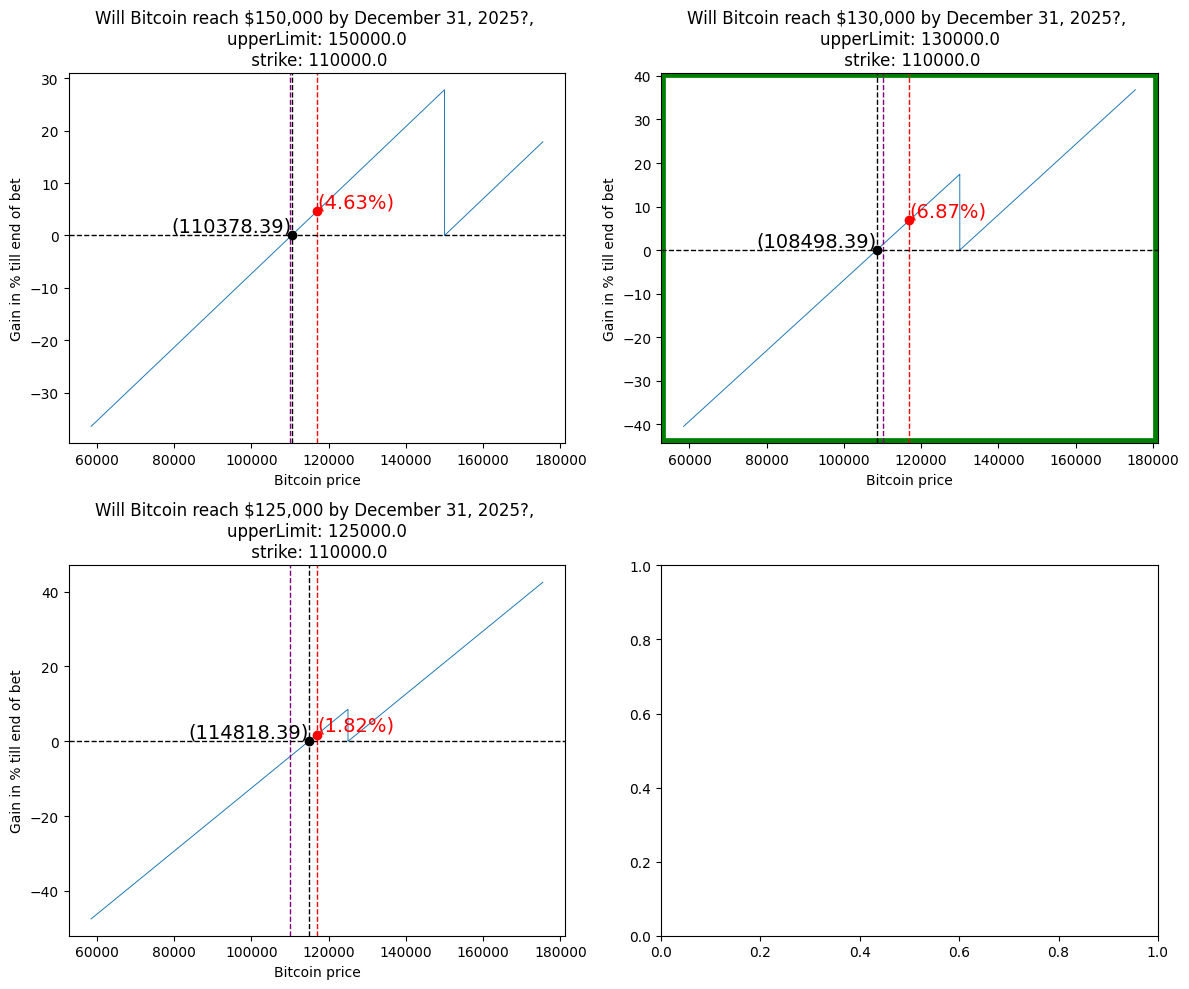

In [6]:
markets = [market for market in btcmarkets[3:9] if "dip" not in market['question'].lower()]

count = 0
for symbol, option in books.items():
    if count > 2:
        break
    count +=1

    strikePrice = extract_strike_binance(symbol)
    premiumFee, _ = option.best_ask()

    # Compute grid size (square-ish layout)
    cols = math.ceil(math.sqrt(len(markets)))
    rows = math.ceil(len(markets) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = np.array(axes).reshape(-1)  # flatten, even if 1D

    currentBtcPrice = get_btc_price_usd()
    bitcoinPricesToCheck = np.arange(0.5*currentBtcPrice, 1.5*currentBtcPrice, 10)
    # bitcoinPricesToCheck= np.array([currentBtcPrice])

    share = 0.2
    minAbsGain = (premiumFee) * share
    capital = (currentBtcPrice + premiumFee) * share

    print(f"Bitcoin price USD: {currentBtcPrice}")
    print(f"Invested in put option ({symbol}),{premiumFee}: {premiumFee * share}")

    for i, polyMarket in enumerate(markets):
        strategy = DeltaHedgeStrategy_NoFees(minAbsGain = minAbsGain , capital_to_invest = capital, bitcoinMarket = {}, polyMarket = polyMarket)
        delta = strategy.calculate_pay_off_curve_buy_now_and_hold(bitcoinPricesToCheck)
        axes[i].set_title(f"{polyMarket['question']}, \nupperLimit: {getUpperLimitForPolyMarketShort(polyMarket)}\n strike: {strikePrice}")
        if delta is None:
            continue  # skip if no data available
        deltaInPercent = delta * 100 # in percent

        # calculate profit for current buyin
        anual_profit_at_current_Price = np.interp(currentBtcPrice, bitcoinPricesToCheck, deltaInPercent)
        axes[i].scatter(currentBtcPrice, anual_profit_at_current_Price, color="red", zorder=5)
        axes[i].text(
            currentBtcPrice, anual_profit_at_current_Price,
            f"({anual_profit_at_current_Price:.2f}%)",
            color="red", fontsize=14, ha="left", va="bottom"
        )

        #calulate point where the put option is needed to avoid losses
        indicesAtLoss = np.where(np.sign(delta[:-1]) != np.sign(delta[1:]))[0]
        assert len(indicesAtLoss) == 1, f"{len(indicesAtLoss)} indices at loss found, expected 1. Check your data."
        btcPriceWherePutIsNeeded = bitcoinPricesToCheck[indicesAtLoss[0]]
        axes[i].axvline(btcPriceWherePutIsNeeded , color="black", linestyle="--", linewidth=1)
        axes[i].scatter(btcPriceWherePutIsNeeded, 0, color="black", zorder=5)
        axes[i].text(
            btcPriceWherePutIsNeeded, 0,
            f"({btcPriceWherePutIsNeeded:.2f})",
            color="black", fontsize=14, ha="right", va="bottom"
        )

        condition = btcPriceWherePutIsNeeded < strikePrice
        if condition:
            print("FOUND")
            # add green box around the whole subplot
            axes[i].add_patch(
                patches.Rectangle(
                    (0, 0), 1, 1,
                    transform=axes[i].transAxes,  # use axes coordinates (0–1)
                    fill=False, edgecolor="green", linewidth=7
                )
            )

        # plot all outcomes
        axes[i].plot(bitcoinPricesToCheck, deltaInPercent, linewidth=0.7)
        axes[i].axvline(x=currentBtcPrice, color="red", linestyle="--", linewidth=1)
        axes[i].axvline(x=strikePrice, color="purple", linestyle="--", linewidth=1)
        axes[i].axhline(y=0, color="black", linestyle="--", linewidth=1)
        axes[i].set_xlabel("Bitcoin price")
        axes[i].set_ylabel("Gain in % till end of bet")
        print("\n\n")

    plt.tight_layout()
    plt.show()

In [7]:
id = 8
print(btcmarkets[id]["question"])
history = PolyMarketInfo.get_market_history(btcmarkets[id]["clobTokenIds"][1], fidelity=0.1)
history2 = PolyMarketInfo.get_market_history(btcmarkets[id]["clobTokenIds"][0], fidelity=0.1)

orderBook = getOrderBookForPolyMarket(btcmarkets[id])
avgPrice, personal_short_hedge_gain = orderBook.calculate_instant_buy_price_and_size(amount_of_money=1, order_type="FOK")

book = PolyMarketInfo().client.get_order_book(btcmarkets[id]["clobTokenIds"][1])
org_avg_price, org_personal_short_hedge_gain = calculateInstantBuyPriceAndAmountOfShares(book.asks, 1, order_type="FOK")



print(avgPrice, personal_short_hedge_gain)
print(org_avg_price, org_personal_short_hedge_gain)

from zoneinfo import ZoneInfo
dt_german = history[-1]["ts"].astimezone(ZoneInfo("Europe/Berlin"))
print(dt_german.strftime("%Y-%m-%d %H:%M:%S"))

print(history[-1])
print(history2[-1])


Will Bitcoin reach $125,000 by December 31, 2025?
0.145 6.896551724137931
0.145 6.896551724137931
2025-08-23 02:54:02
{'ts': datetime.datetime(2025, 8, 23, 0, 54, 2, tzinfo=datetime.timezone.utc), 'midPointPrice': 0.141}
{'ts': datetime.datetime(2025, 8, 23, 0, 54, 3, tzinfo=datetime.timezone.utc), 'midPointPrice': 0.859}
